In [ ]:
#IMPORTANT: RUN THESE ANSWERS CONSECUTIVELY AS SOME ANSWERS OR DEFINITIONS ARE REUSED IN THE FOLLOWING QUESTION
#IF YOU DONT RUN ALL THE CODE BEFORE A CERTAIN PART, YOU MIGHT GET AN ERROR

In [1]:
from os import access
import pandas as pd
import numpy as np
import datetime
from pandas.core.reshape.concat import concat
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from datetime import date, datetime,timedelta
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as st
!pip install haversine
import haversine as hs
from itertools import permutations, combinations
from collections import Counter
!pip install pandas MLxtend
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [2]:
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping EmployeeData (HVC_AM0)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------

#Reading the file and storing each line in the list text
with open ("HVC_AM0.csv", "r") as f:
    textEmployees = f.readlines()
textEmployees.pop(0)

#We make a dictionnary based on the data
CompanyEmployeesDict = {}

for e in textEmployees:
    Employee_ID, EmployeeNumber, Name, Postcode, Location, Language = e.replace("\n","").split(";")
    Employee_ID=int(Employee_ID)
    Postcode=int(Postcode)
    CompanyEmployeesDict[Employee_ID]= {"EmployeeNumber":EmployeeNumber,"Name": Name, "Postcode": Postcode, "Location": Location,"Language": Language }


#Some Employees do not have a EmployeeNumber: We set the EmployeeNumber of these employees to 0
#In this way we can convert all to a float
for e in CompanyEmployeesDict:
    E_ID = CompanyEmployeesDict[e]["EmployeeNumber"]
    if(E_ID == ""):
        CompanyEmployeesDict[e]["EmployeeNumber"]="0"
    CompanyEmployeesDict[e]["EmployeeNumber"] = int(float(CompanyEmployeesDict[e]["EmployeeNumber"]))   

df_CompanyEmployees = pd.DataFrame.from_dict(CompanyEmployeesDict, orient = 'index')


#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping ProductData (HVC_AR0)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------


with open ("HVC_AR0.csv", "r") as f:
    textProducts = f.readlines()
textProducts.pop(0)

CompanyProductsDict = {}
for e in textProducts:
    ProductID, Description, Category, Family, Price = e.replace("\n","").split(";")
    ProductID = int(ProductID)
    CompanyProductsDict[ProductID]= {"Description":Description,"Category": Category, "Family": Family, "Price": Price}
   
#Some prices are missing   
for e in CompanyProductsDict:
  PriceCheck = CompanyProductsDict[e]["Price"]
  if(PriceCheck==""):
        CompanyProductsDict[e]["Price"]="0.0"
  CompanyProductsDict[e]["Price"]=float(CompanyProductsDict[e]["Price"])  

#Whenever they are Coupons they are not assigned a family
#We assign Coupon to its Family for clearity
for e in CompanyProductsDict:
  PriceCheck = CompanyProductsDict[e]["Family"]
  if(PriceCheck==""):
        CompanyProductsDict[e]["Family"]="Coupon"

df_Products = pd.DataFrame.from_dict(CompanyProductsDict, orient = 'index')


#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping Reviews Data (HVC_CUSTOMER_REVIEWS)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------   


with open ("HVC_CUSTOMER_REVIEWS.csv", "r") as f:
    textCustReviews = f.readlines()
textCustReviews.pop(0)

CompanyReviewsDict = {}
for e in textCustReviews:
    CustomerID, Review  = e.replace("\n","").split(";")
    CustomerID = int(CustomerID)
    CompanyReviewsDict[CustomerID]= {"Review": Review}

df_Reviews = pd.DataFrame.from_dict(CompanyReviewsDict, orient = 'index')


#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping Depot data (HVC_DEPOT)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------


#Reading the file and storing each line in the list text
with open ("HVC_DEPOT.csv", "r") as f:
    text_Depot = f.readlines()
text_Depot.pop(0)

#We make a dictionnary based on the data
Depot_Dict = {}

for dep in text_Depot:
    Depot_Id, Depot_Location, Depot_Route = dep.replace("\n","").split(";")
    Depot_Id = int(Depot_Id)
    Depot_Route = int(Depot_Route)
    Depot_Dict[Depot_Id] = {"DEPOT":Depot_Location, "HVROUTETEMPLATE_NRID":Depot_Route}

#The Depot_Id and HVROUTETEMPLATE_NRID are both integers, Depot_Location
#The names of the keys are based on the table descriptions for easy looking up in case of further calculations
#There are no missing values in our dictionnary so further preprocessing is not necessary.

df_Depot = pd.DataFrame.from_dict(Depot_Dict, orient = 'index')


#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping DaysOfWeek (HVC_HVDAYOFWEEK)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------


with open ("HVC_HVDAYOFWEEK.csv", "r") as f:
    text_DayOfWeek = f.readlines()
text_DayOfWeek.pop(0)

#We make a dictionnary based on the data
DayOfWeek_Dict = {}

for day in text_DayOfWeek:
    HVDAYOFWEEK_NRID, DAY = day.replace("\n","").split(";")
    HVDAYOFWEEK_NRID = int(float(HVDAYOFWEEK_NRID))
    DayOfWeek_Dict[int(HVDAYOFWEEK_NRID)] = DAY


#The HVDAYOFWEEK_NRID is an integer, DAY is a string. 
#!! important notice for further caclulations, the first day (day with id = 1) is a sunday! Not a monday!
df_DaysOfWeek = pd.DataFrame.from_dict(DayOfWeek_Dict, orient = 'index')


#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping Position data (HVC_HVPOSITION)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------


with open ("HVC_HVPOSITION_CORRECT.csv", "r") as f:
    text_Position = f.readlines()
text_Position.pop(0)

#We make a dictionnary based on the data
Position_Dict = {}

for loc in text_Position:
    SO0_NRID, LONG, LAT = loc.replace("\n","").split(";")
    SO0_NRID = int(float(SO0_NRID))
    LONG = float(LONG)
    LAT = float(LAT)
    Position_Dict[SO0_NRID] = {"LONG":LONG, "LAT":LAT}

#SO0_NRID is int, LONG and LAT are both float values.

df_Position = pd.DataFrame.from_dict(Position_Dict, orient = 'index')


#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping Route Template data (HVC_HVROUTETEMPLATE)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------


with open ("HVC_HVROUTETEMPLATE.csv", "r") as f:
    textRouteTemplate = f.readlines()
    textRouteTemplate.pop(0)
    
RouteTemplate_Dict = {}

for route in textRouteTemplate:
    HVROUTETEMPLATE_NRID, REGION, WEEKORDER, HVDAYOFWEEK_NRID = route.replace("\n","").split(";")
    HVROUTETEMPLATE_NRID=int(float(HVROUTETEMPLATE_NRID))
    RouteTemplate_Dict[HVROUTETEMPLATE_NRID] = {"REGION": REGION, "WEEKORDER": WEEKORDER, "DAYOFWEEK_NRID": HVDAYOFWEEK_NRID}        

df_RouteTemplate = pd.DataFrame.from_dict(RouteTemplate_Dict, orient = 'index')


#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping Visit Outcome data (HVC_HVVISITOUTCOME)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------


with open ("HVC_HVVISITOUTCOME.csv", "r") as f:
    textVisitOutcome = list()
    for line in f:
        line = line.replace("\n","")
        obs = line.split(";")
        textVisitOutcome.append(obs)

column_names = textVisitOutcome[0]
textVisitOutcome.pop(0)
VisitOucome_Dict = {}

for visit in textVisitOutcome:
    VisitOucome_Dict[visit[1]] = visit[0]


df_VisitOutcome = pd.DataFrame.from_dict(VisitOucome_Dict, orient = 'index')


#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping TransactionData (HVC_HVVISITRESULT)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------


#Reading the file and storing each line in the list text
with open ("HVC_HVVISITRESULT.csv", "r") as f:
    textVisit = f.readlines()
textVisit.pop(0)

#We make a dictionnary based on the data
CompanyVisitDict = {}

for e in textVisit:
    Visit_ID, Customer_ID, Employee_ID, VisitOutcome_ID, Time, Date, Amount, paymentMethod = e.replace("\n","").split(";")
    Visit_ID= int(Visit_ID)

    yYear, mMonth, dDay = Date.split("-")
    yYear = int(yYear)
    mMonth = int(mMonth)
    dDay = int(dDay)
    Date=date(yYear,mMonth,dDay)

    Customer_ID= int(Customer_ID)
    Employee_ID= int(Employee_ID)
    VisitOutcome_ID= int(VisitOutcome_ID)
    Amount= float(Amount)
    CompanyVisitDict[Visit_ID]= {"Customer_ID":Customer_ID,"Employee_ID": Employee_ID, "VisitOutcome_ID": VisitOutcome_ID, "Time": Time,"Date": Date, "Amount": Amount, "paymentMethod": paymentMethod }

#Some visits do not have a payment method recorded: We set the paymentMethod of these cases to the None variable
#Maybe these missing values will have value later on
for e in CompanyVisitDict:
    P_method = CompanyVisitDict[e]["paymentMethod"]
    if(P_method == ""):
        CompanyVisitDict[e]["paymentMethod"]= None

df_CompanyVisit = pd.DataFrame.from_dict(CompanyVisitDict, orient = 'index')

#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping EmployeeData (HVC_SO0)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------


#Reading the file and storing each line in the list text
with open ("HVC_SO0.csv", "r") as f:
    textCustomerType = f.readlines()
textCustomerType.pop(0)

#We make a dictionnary based on the data
CustomerTypeDict = {}

for e in textCustomerType:
    Customer_ID, RouteTemplate_ID, CustomerType, Postcode, Language, Season = e.replace("\n","").split(";")
    Customer_ID=int(float(Customer_ID))
    RouteTemplate_ID=int(float(RouteTemplate_ID))
    Postcode = int(float(Postcode))
    CustomerTypeDict[Customer_ID]= {"RouteTemplate_ID":RouteTemplate_ID,"CustomerType": CustomerType, "Postcode": Postcode, "Language": Language,"Season": Season}


df_CustomerType = pd.DataFrame.from_dict(CustomerTypeDict, orient = 'index')

#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping ProductData (HVC_VISITRESULTDETAILS)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------


with open ("HVC_VISITRESULTDETAILS.csv", "r") as f:
    textVisitDetails = f.readlines()
textVisitDetails.pop(0)


#We make a dictionnary based on the data
VisitDetailsDict = {}


for e in textVisitDetails:
    VisitDetails_ID, Product_ID, Quantity, Visit_ID = e.replace("\n","").split(";")
    VisitDetails_ID=int(VisitDetails_ID)
    Product_ID=int(Product_ID)
    Quantity=int(float(Quantity))
    Visit_ID=int(float(Visit_ID))
    VisitDetailsDict[VisitDetails_ID]= {"Product_ID":Product_ID,"Quantity": Quantity, "Visit_ID": Visit_ID}

df_VisitDetails = pd.DataFrame.from_dict(VisitDetailsDict, orient = 'index')


#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#This gives us the following 11 dataframes to work with:
# 1  df_CompanyEmployees (HVC_AM0)
# 2  df_Products (HVC_AR0)
# 3  df_Reviews  (HVC_CUSTOMER_REVIEWS)
# 4  df_Depot  (HVC_DEPOT)
# 5  df_DaysOfWeek (HVC_HVDAYOFWEEK)
# 6  df_Position (HVC_HVPOSiTION)
# 7  df_RouteTemplate (HVC_HVROUTETEMPLATE)
# 8  df_VisitOutcome (HVC_HVVISITOUTCOME)
# 9  df_CompanyVisit (HVC_VISITRESULT)
# 10 df_CustomerType (HVC_SO0)
# 11 df_VisitDetails (HVC_VISITRESULTDETAILS)

#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [3]:
###########################
#Q1: What are the Products?
###########################

In [4]:
#Here we make a complete price frame containing: VisitID's, corresponding Customer_ID's
#And the corresponding Product_ID's bought during those visits
#For visitdetails (which products bought)
df_CustomerType["Customer_ID"] = df_CustomerType.index
df_CompanyVisit["Visit_ID"] = df_CompanyVisit.index
df_Products["Product_ID"] = df_Products.index


df_SeasonPrep = pd.merge(df_CompanyVisit, df_VisitDetails, how="left", on="Visit_ID")

#Now for product info
df_CompletePriceFrame = pd.merge(df_SeasonPrep, df_Products, how="left", on="Product_ID").dropna()

#What revenue is gained for each single product during a single visit
df_CompletePriceFrame["RevenueProduct"] = df_CompletePriceFrame["Quantity"]*df_CompletePriceFrame["Price"]

#Drop unneeded columns
df_CompletePriceFrame = df_CompletePriceFrame.drop(columns=["Time","paymentMethod"])

In [5]:
#Q1.1 What are the most frequently bought products?
#We sum all quantities over it's unique product_ID
#in this way we get the total amount a certain product/product_ID is bought
#over all visits
BestAmountSoldProducts = df_CompletePriceFrame.groupby("Product_ID")["Quantity"].sum()
BestAmountSoldProducts =BestAmountSoldProducts.sort_values(ascending=False)
BestAmountSoldProducts = pd.merge(BestAmountSoldProducts, df_Products, how="left", on="Product_ID")

#print(BestAmountSoldProducts.head(10))

In [6]:
#Q1.2 Which products render the most revenue?
#By sorting on this column and putting ascending to False
#We get the products with their description with the best revenue on top
#The anwser can be found by printing the head of this dataframe
BestRevProducts = df_CompletePriceFrame.groupby("Product_ID")["RevenueProduct"].sum()
BestRevProducts =BestRevProducts.sort_values(ascending=False)
#We merge for product info
BestRevProducts = pd.merge(BestRevProducts, df_Products, how="left", on="Product_ID")

#print(BestRevProducts.head(12))

In [7]:
#Q1.3 Which products are bought the most in the region of Brussels, Antwerp, …?
# merge routetemplate and depot to see if the region code and depot location are connected
# first we define the keys of the Route Template dataframe as an extra column so they can be accessed
# then we give the keys of the depot an appropriate name in order to merge them with more convenience
df_RouteTemplate["RouteTemplate_ID"] = df_RouteTemplate.index
df_Depot["RouteTemplate_ID"] = df_Depot["HVROUTETEMPLATE_NRID"]
RouteTemplate_with_DepotLocation = pd.merge(df_RouteTemplate, df_Depot, how = "inner", on = "RouteTemplate_ID")
RouteTemplate_with_DepotLocation.head(5)

# out of the previous dataframe it becomes clear that the location of the depot and the region code are not always 
# the same for each location
# now we are going to create a dataframe in which the quantity of the products sold and the location of the depot
# are both present, therefore we have to merge multiple dataframes
Customer_with_DepotLocation = pd.merge(df_CustomerType, RouteTemplate_with_DepotLocation, how = "inner", on = "RouteTemplate_ID")
Customer_with_DepotLocation

# To merge the following dataframes, we first need to create an extra column with the customer ID's 
# for the CustomerType so they can be accessed in the future, the same goes for the Visit_ID of CompanyVisit
# and the product_ID of products
df_CustomerType["Customer_ID"] = df_CustomerType.index
df_CompanyVisit["Visit_ID"] = df_CompanyVisit.index
df_Products["Product_ID"] = df_Products.index

# merge the Customer_with_DepotLocation dataframe with the results of the visit (= dataframe CompanyVisit)
Visit_with_DepotLocation = pd.merge(Customer_with_DepotLocation, df_CompanyVisit, how = "inner", on = "Customer_ID")
Visit_with_DepotLocation

# now we are going to merge this dataframe, with the VisitDetails dataframe in order to gain information about the
# product_ID's and the quantities sold
Quantity_with_DepotLocation = pd.merge(Visit_with_DepotLocation, df_VisitDetails, how = "inner", on = "Visit_ID")

# here we already are going to look in which depots the most quantities are sold
Quantity_with_DepotLocation.groupby("DEPOT")["Quantity"].sum()

# Now we are going to look which products are most sold in which region?
# probleem hier nog: als regio heb ik gewoon de locaties van de depots genomen, maar in de vraag staat er ook Brussel
# en andere steden, dus meer dan enkel de depots
# zou ik dan postcodes moeten gaan verwerken naar regio's of die region codes gaan ontcijferen?
# with the location of the depots I worked as followed:
# 1) first I merged the previous dataframe Quantity_with_DepotLocation with df_Products on product_ID in order to
# get more information about the product and its description
# 2) then i created 4 subsamples (= the four locations of the depots)
# 3) i looked in every dataframe which product was sold how many times by grouping the dataframe by 
# its product_ID and taking the sum of the quantities and stored this data per location/sub_dataframe
# 4) Next we merge this dataframe with df_products so we can get the description
# Family and all other information on every single Product_ID

# 1) 
Products_with_DepotLocation_1 = pd.merge(Quantity_with_DepotLocation, df_Products, how = "inner", on = "Product_ID")
Products_with_DepotLocation_1

# 2)# make a subselection of the dataframe based on the location of the depot
df_Deinze = Products_with_DepotLocation_1[Products_with_DepotLocation_1["DEPOT"] == "Deinze"]
df_Aarschot = Products_with_DepotLocation_1[Products_with_DepotLocation_1["DEPOT"] == "Aarschot"]
df_Antwerpen = Products_with_DepotLocation_1[Products_with_DepotLocation_1["DEPOT"] == "Antwerpen"]
df_Vilvoorde = Products_with_DepotLocation_1[Products_with_DepotLocation_1["DEPOT"] == "Vilvoorde"]

# 3 + 4) 

product_quantities_Deinze = df_Deinze.groupby("Product_ID")["Quantity"].sum()
df_Products_Deinze = pd.merge(product_quantities_Deinze, df_Products, how = "inner", on = "Product_ID")
#print(df_Products_Deinze.sort_values(by = "Quantity", ascending = False).head(10))

product_quantities_Aarschot = df_Aarschot.groupby("Product_ID")["Quantity"].sum()
df_Products_Aarschot = pd.merge(product_quantities_Aarschot, df_Products, how = "inner", on = "Product_ID")
#print(df_Products_Aarschot.sort_values(by = "Quantity", ascending = False))

product_quantities_Antwerpen = df_Antwerpen.groupby("Product_ID")["Quantity"].sum()
df_Products_Antwerpen = pd.merge(product_quantities_Antwerpen, df_Products, how = "inner", on = "Product_ID")
#print(df_Products_Antwerpen.sort_values(by = "Quantity", ascending = False))

product_quantities_Vilvoorde = df_Vilvoorde.groupby("Product_ID")["Quantity"].sum()
df_Products_Vilvoorde = pd.merge(product_quantities_Vilvoorde, df_Products, how = "inner", on = "Product_ID")
#print(df_Products_Vilvoorde.sort_values(by = "Quantity", ascending = False))


In [8]:
# Q1.4 Are some products often purchased together?
# To answer this question, we will first look at which products were often bought together.
# We will create pairs in the purchased products and store them in a list
# Then we will calculate how many times each pair occurs.
# Second, we will look at how often product families were bought together through the same principle

# 1) How often were products puchased together
# First, we create a dataset with all the necessary information about product purchases
# We merge the visitDetails with the information about the products
# This only contains sales information as there is only details about the visit available when 
# a sale happened
df_Products["Product_ID"] = df_Products.index
df_visit_products = pd.merge(df_Products, df_VisitDetails, how = "inner", on = "Product_ID")
print(df_visit_products)


# create a function that finds pairs in the purchased products and list 
# and list them in a column, using A and B as stand-in
def find_pairs(x):
    pairs = pd.DataFrame(list(permutations(x.values, 2)), columns = ["A", "B"])
    return pairs


                      Description         Category  Family  Price  \
0              Dessert Caramel/14  Verkoopsartikel    Cups   10.9   
1              Dessert Caramel/14  Verkoopsartikel    Cups   10.9   
2              Dessert Caramel/14  Verkoopsartikel    Cups   10.9   
3              Dessert Caramel/14  Verkoopsartikel    Cups   10.9   
4              Dessert Caramel/14  Verkoopsartikel    Cups   10.9   
...                           ...              ...     ...    ...   
126773  Bon 1L roomijs naar keuze      Kortingsbon  Coupon   -3.9   
126774  Bon 1L roomijs naar keuze      Kortingsbon  Coupon   -3.9   
126775  Bon 1L roomijs naar keuze      Kortingsbon  Coupon   -3.9   
126776  Bon 1L roomijs naar keuze      Kortingsbon  Coupon   -3.9   
126777  Bon 1L roomijs naar keuze      Kortingsbon  Coupon   -3.9   

            Product_ID  Quantity  Visit_ID  
0       20742288286838         1  55925160  
1       20742288286838         1  55889621  
2       20742288286838         1  56

In [9]:
# group the products by Visit_ID and then apply the function for the product description
#This gives a matrix for all pairwise purchases

# THIS TAKES 2-5 MIN to run!!!
dataset_combo = df_visit_products.groupby("Visit_ID")["Description"].apply(find_pairs).reset_index(drop = True)


#dataset_combo.head()

In [10]:
# Calculate how often each pair dus occur
dataset_combo2 = dataset_combo.groupby(["A", "B"]).size()
dataset_combo2

# create a sorted dataframe by the most frequent combinations
most_frequent_combinations = dataset_combo2.reset_index()
most_frequent_combinations.columns = ["A", "B", "Frequency"]
most_frequent_combinations.sort_values(by = "Frequency", ascending = False, inplace = True)
most_frequent_combinations.head(5)

# now we are going to clean this dataset as there are duplicates for each row
most_frequent_combinations_clean = most_frequent_combinations.iloc[::2]

#most_frequent_combinations_clean.head(10)

In [11]:
# 2) How often were product families puchased together
# group the products by Visit_ID and then apply the function for the product family

# THIS TAKES 5 MIN to run
dataset_combo_family = df_visit_products.groupby("Visit_ID")["Family"].apply(find_pairs).reset_index(drop = True)

dataset_combo_family.head()

,A,B
0,Meals,Garniture
1,Meals,Ice Cakes
2,Garniture,Meals
3,Garniture,Ice Cakes
4,Ice Cakes,Meals


In [12]:
# Calculate how often each pair dus occur
dataset_combo_family2 = dataset_combo_family.groupby(["A", "B"]).size()
dataset_combo_family2

# create a sorted dataframe by the most frequent combinations
most_frequent_familyCombinations = dataset_combo_family2.reset_index()
most_frequent_familyCombinations.columns = ["A", "B", "Frequency"]
most_frequent_familyCombinations.sort_values(by = "Frequency", ascending = False, inplace = True)
most_frequent_familyCombinations.head(5)

# now we are going to clean this dataset as there are duplicates for each row
most_frequent_Familycombinations_clean = most_frequent_familyCombinations.iloc[::2]

most_frequent_Familycombinations_clean.head(10)

,A,B,Frequency
78,Hand Ice,Hand Ice,27944
137,Scoop Ice,Hand Ice,10759
76,Hand Ice,Cups,8778
52,Cups,Cups,4618
91,Ice Cakes,Ice Cakes,3226
71,Garniture,Scoop Ice,3104
135,Scoop Ice,Cups,3017
102,Individual Dessert,Hand Ice,2453
107,Individual Dessert,Scoop Ice,1926
93,Ice Cakes,Meals,1659


In [13]:
# first, we create the appropriate dataframe for this question
# df_cross_rec stands for cross selling recommendations (of products)
df_Products["Product_ID"] = df_Products.index
df_cross_rec = pd.merge(df_Products, df_VisitDetails, how = "inner", on = "Product_ID")

# we convert VisitID to a string as this is necessary for the imported functions
# now we are going to do two analyses, one for the correlation and cross selling of products 
# and one for the correlation and cross selling of family products
df_cross_rec['Visit_ID'] = df_cross_rec['Visit_ID'].astype('str')

# This part will cover the analysis regarding the correlation and cross selling per product
market_basket = df_cross_rec.groupby(['Visit_ID', 'Description'])['Quantity']

# Next, we want to encode the data and get 1 transaction per row to prepare to run our mlxtend analysis.
market_basket = market_basket.sum().unstack().reset_index().fillna(0).set_index('Visit_ID')
# print(market_basket.head(5))

# If there is a zero, that means those products haven’t sold together. 
# Before we continue, we want to convert all of our numbers to either a `1` or a `0`
# Therefore, we define the following function
def encode_data(datapoint):
    if datapoint <= 0:
        return 0
    if datapoint >= 1:
        return 1

# now we are going to apply this function to create our desired dataset:
market_basket = market_basket.applymap(encode_data)
# print(market_basket.head(5))

# out of this dataframe, we can calculate the correlation between product purchases:
corr_product_purchases = market_basket.corr()
# print(corr_product_purchases)

# Now, we have the correlation between the purchases of the products for all the products
# However, it is difficult to analyse this huge dataset
# the following code generates the pairwise correlation between two products
correlation_products = corr_product_purchases.unstack()
product_correlation_serie = correlation_products.sort_values(kind="quicksort")


# now, we have a type serie overview of the correlation between the products
# First, we are going to clean this dataset
# if the correlation is one, it is the correlation of the product with itself so we drop this data
# next, we drop the rows who show a pair of products that has already been showed
product_correlation_serie_2 = product_correlation_serie[product_correlation_serie != 1]
product_correlation_serie_3 = product_correlation_serie_2.iloc[::2]
product_correlation_serie_3.sort_values(ascending = False).head(50)

# last, we create a dataframe and show the most important product combinations in a easy-view table
correlated_products = product_correlation_serie_3.to_frame()
correlated_products.sort_values(by = 0, ascending = False).head(5)

,,0
Description,Description,
"2x2,5L Caramelo Crunch (Caddy)","2x2,5L Malaga (caddy)",0.666641
5 L.Aardbei Extra (Caddy),"2x 2,5LRio (caddy)",0.629788
"2x2,5L Caramelo Crunch (Caddy)","2x2,5LSorbet Framboos (Caddy)",0.577336
"2x2,5LSorbet Framboos (Caddy)","2x2,5L Malaga (caddy)",0.577336
"2x2,5L Caramelo Crunch (Caddy)","2x2,5L Cappucino(caddy)",0.577314


In [14]:
# This part covers the analysis of the correlation and product purchases within products families
market_basket_fam = df_cross_rec.groupby(['Visit_ID', 'Family'])['Quantity']

# Next, we want to hot encode the data and get 1 transaction per row to prepare to run our mlxtend analysis.
market_basket_fam = market_basket_fam.sum().unstack().reset_index().fillna(0).set_index('Visit_ID')
market_basket_fam.head(5)

market_basket_fam = market_basket_fam.applymap(encode_data)
#print(market_basket_fam.head(20))

corr_product_purchases_fam = market_basket_fam.corr()
#corr_product_purchases_fam.head(20)

In [15]:
#Q1.5 What are the total sales generated for each product family?
#Using the earlier dataframes based on quantity and revenue we can anwser these questions
#By simply grouping over each Family or Catogory and then taking the sum of either Revenue or Quanitity
#And then sorting the values to get the largest on top
#This way if we group on a family and then sum each revenue from all products for that family for example
#We can anwser the question 

#Based on Family
#Generated Revenue
BestRevFamily=df_CompletePriceFrame.groupby("Family")["RevenueProduct"].sum().sort_values(ascending=False)
#Based on Family
#Amount sold
BestAmountFamily=df_CompletePriceFrame.groupby("Family")["Quantity"].sum().sort_values(ascending=False)

#Based on Catogery
#Generated Revenue
BestRevCat=df_CompletePriceFrame.groupby("Category")["RevenueProduct"].sum().sort_values(ascending=False)

#Based on Catogery
#Amount sold
BestAmountCat=df_CompletePriceFrame.groupby("Category")["Quantity"].sum().sort_values(ascending=False)

#The anwser can be found by printing all the dataframes
#The dataframes are not big so no need to use head

#print(BestRevFamily)
print(BestAmountFamily)
#print(BestRevCat)


Family
Scoop Ice             46200.0
Hand Ice              42333.0
Cups                  13826.0
Individual Dessert     9810.0
Ice Cakes              7792.0
Coffee                 4870.0
Meals                  4842.0
Assortments            4697.0
Garniture              3566.0
BIG                    1600.0
Coupon                 1065.0
POS inside               59.0
Name: Quantity, dtype: float64


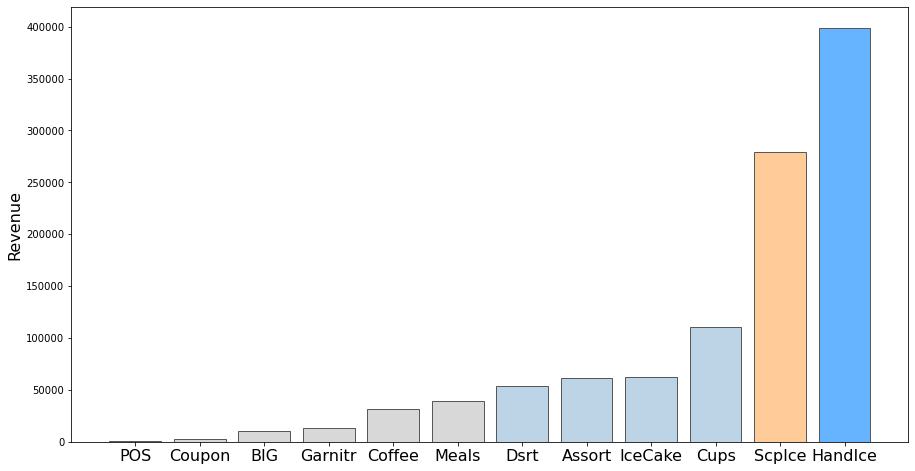

In [16]:
#We make a barplot from these observations
BestRevFamily=BestRevFamily.sort_values()
family = ['POS', 'Coupon', 'BIG', 'Garnitr', 'Coffee', 'Meals',
       'Dsrt', 'Assort', 'IceCake', 'Cups', 'ScpIce',
       'HandIce']
revenue = BestRevFamily.values

colors=["#D8D8D8","#D8D8D8","#D8D8D8","#D8D8D8","#D8D8D8","#D8D8D8","#bcd4e6","#bcd4e6","#bcd4e6","#bcd4e6","#ffcc99","#66b3ff"]
plt.figure(figsize=(15,8))
plt.bar(range(12), revenue, color=colors,  edgecolor='#585858')
plt.xticks(range(12),family, size=16)
plt.ylabel("Revenue", size=16)

plt.show()

In [17]:
#Q1.6 Does the weather / seasonal changes have an effect on the total revenue?

#This is used to define a function that calculates which season a given date is
#This function: 'get_season' returns the season of a date
Y=2020
seasons = [('Winter', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('Spring', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('Summer', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('Autumn', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('Winter', (date(Y, 12, 21),  date(Y, 12, 31)))]

def get_season(now):
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)

#We then apply this function on the column Date to get the Seasons
#We store the correspondent season on a new column in the dataframe: "Season"

df_CompletePriceFrame["Season"]=df_CompletePriceFrame["Date"].apply(get_season)
#By grouping on Season and taking the sum of Revenues for each product for each season we can anwser the question
df_Seasonality=df_CompletePriceFrame.groupby("Season")["RevenueProduct"].sum()
#Use percentages
df_Seasonality=(df_Seasonality/df_Seasonality.values.sum())*100

#THIS IS EXPRESSED IN PERCENTAGES
#print(df_Seasonality.head(5))

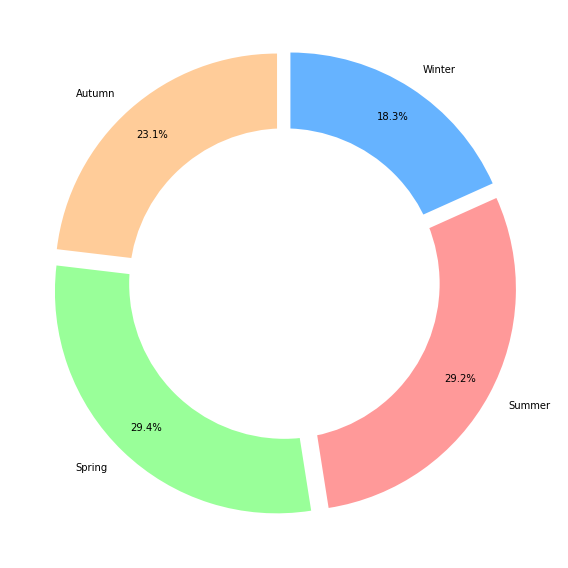

In [18]:
#We plot this in a pie chart
#Plotting pie Chart:
labels = ['Autumn', 'Spring', 'Summer', 'Winter']
sizes = df_Seasonality.values

#colors
colors = ['#ffcc99','#99ff99','#ff9999','#66b3ff']
#explsion
explode = (0.05,0.05,0.05,0.05)
 
plt.figure(figsize=(16,8))
plt.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()

#plt.rc('font', **font)
plt.show()

In [19]:
#We now will look if bought families differ between seasons
#To do this we will split our data into 4 different sets: one for each season

#We now look at each season seperately by splitting the data in respective dataframes
df_Winter = df_CompletePriceFrame[df_CompletePriceFrame["Season"]=="Winter"]
df_Spring = df_CompletePriceFrame[df_CompletePriceFrame["Season"]=="Spring"]
df_Summer = df_CompletePriceFrame[df_CompletePriceFrame["Season"]=="Summer"]
df_Autumn = df_CompletePriceFrame[df_CompletePriceFrame["Season"]=="Autumn"]


#Sum over Family
df_WinterFamily= df_Winter.groupby("Family")["RevenueProduct"].sum()
df_SpringFamily= df_Spring.groupby("Family")["RevenueProduct"].sum()
df_SummerFamily= df_Summer.groupby("Family")["RevenueProduct"].sum()
df_AutumnFamily= df_Autumn.groupby("Family")["RevenueProduct"].sum()

#print(df_WinterFamily.sort_values(ascending=False).head(5))
#print(df_SummerFamily.sort_values(ascending=False).head(5))
#print(df_SpringFamily.sort_values(ascending=False).head(5))
#print(df_AutumnFamily.sort_values(ascending=False).head(5))

#No conclusion: Sales amounts differ but proportionality of families not really

#Sum over Cat
df_WinterCat= df_Winter.groupby("Category")["RevenueProduct"].sum()
df_SpringCat= df_Spring.groupby("Category")["RevenueProduct"].sum()
df_SummerCat= df_Summer.groupby("Category")["RevenueProduct"].sum()
df_AutumnCat= df_Autumn.groupby("Category")["RevenueProduct"].sum()

#print(df_WinterCat.sort_values(ascending=False).head(5))
#print(df_SummerCat.sort_values(ascending=False).head(5))
#print(df_SpringCat.sort_values(ascending=False).head(5))
#print(df_AutumnCat.sort_values(ascending=False).head(5))

#Also no conlusions to be made

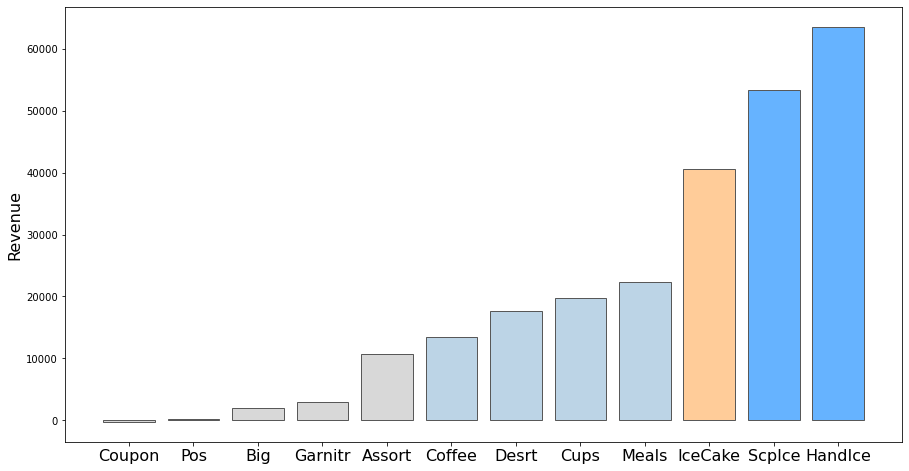

In [20]:
#We make a barplot from these observations
df_AutumnFamily=df_AutumnFamily.sort_values()
familyAutumn = ["Coupon", "Pos", "Big", "Garnitr","Assort","Coffee","Desrt","Cups","Meals","IceCake", "ScpIce","HandIce"]
revenueAutumn = df_AutumnFamily.values

colors=["#D8D8D8","#D8D8D8","#D8D8D8","#D8D8D8","#D8D8D8","#bcd4e6","#bcd4e6","#bcd4e6","#bcd4e6","#ffcc99","#66b3ff","#66b3ff"]
plt.figure(figsize=(15,8))
plt.bar(range(12), revenueAutumn, color=colors,  edgecolor='#585858')
plt.xticks(range(12),familyAutumn, size=16)
plt.ylabel("Revenue", size=16)

plt.show()